# Test Solver Parameters
Test how much adjusting the various solver parameters affects the size of the results file versus the results.

In [485]:
import os
import sys
import subprocess
import copy

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sys.path.append('/home/wtb2/Documents/codes/ebtelPlusPlus/rsp_toolkit/python/')
from xml_io import InputHandler,OutputHandler

%matplotlib inline

In [486]:
class EbtelRun(object):
    def __init__(self,data,params):
        self.temperature = data[:,1] 
        self.density = data[:,3]
        self.time = data[:,0]
        self.size = data.shape[0]
        self.params = params

In [495]:
ih = InputHandler('/home/wtb2/Documents/codes/ebtelPlusPlus/config/ebtel.example.cfg.xml')
base_config = ih.lookup_vars()
base_config['use_adaptive_solver'] = True
base_config['adaptive_solver_safety'] = 0.1
base_config['use_flux_limiting'] = True
base_config['output_filename'] = 'test_solver_params.dat'
base_config['total_time'] = 20000
base_config['loop_length'] = 4e9
base_config['heating']['background'] = 3.5e-5
base_config['heating']['events'] = []
tn = 750.
tau = 200.
for i in range(int(np.ceil(base_config['total_time']/(tau+tn)))):
    ts = i*(tn+tau)
    base_config['heating']['events'].append(
        {'event': 
         {'rise_start':ts,
          'rise_end':ts+tau/2.,
          'decay_start':ts+tau/2.,
          'decay_end':ts+tau,
          'magnitude':1.*np.random.rand()
         }
        }
    )

In [496]:
solver_errors = np.logspace(-12,-2,10)
runs = []

In [497]:
for error in solver_errors:
    oh = OutputHandler('test_solver_params.xml',base_config)
    oh.output_dict['adaptive_solver_error'] = error
    oh.print_to_xml()
    subprocess.call([os.path.join('/home/wtb2/Documents/codes/','ebtelPlusPlus/bin/ebtel++.run'),
                     '-c','test_solver_params.xml'])
    data = np.loadtxt(oh.output_dict['output_filename'])
    runs.append(EbtelRun(copy.deepcopy(data),copy.deepcopy(oh.output_dict)))

(0, 20000)

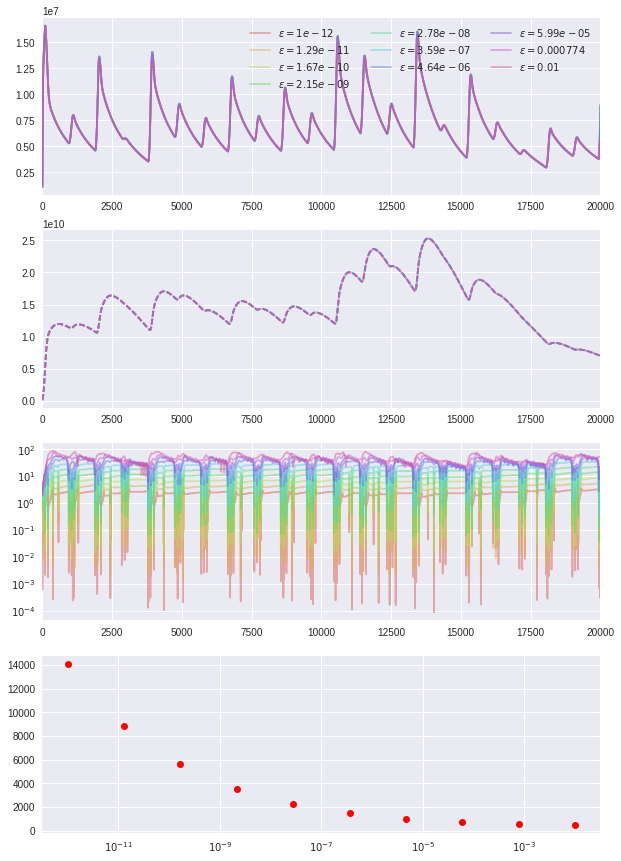

In [498]:
colors=sns.color_palette('hls',len(runs))
fig,axes = plt.subplots(4,1,figsize=(10,15))
for r in runs:
    axes[0].plot(r.time,
                 r.temperature,
                 color=colors[runs.index(r)],
                 label=r'$\varepsilon={:.3g}$'.format(r.params['adaptive_solver_error']),
                 alpha=0.5)
    axes[1].plot(r.time,
                 r.density,
                 color=colors[runs.index(r)],ls='--',
                 alpha=0.5)
    axes[3].plot(r.params['adaptive_solver_error'],r.size,'or')
    axes[2].plot(r.time,np.gradient(r.time),color=colors[runs.index(r)],alpha=0.5)
axes[3].set_xscale('log')
axes[0].legend(loc='best',ncol=3)
axes[2].set_yscale('log')
#axes[3].set_yscale('log')
axes[0].set_xlim([0,
                  base_config['total_time']
                 ])
axes[1].set_xlim([0,
                  base_config['total_time']
                 ])
axes[2].set_xlim([0,
                  base_config['total_time']
                 ])
#axes[2].set_ylim([5e0,
#                  2e2
#                 ])
#axes[2].axvline(x=4200)
#axes[3].set_ylim([10,2e4])